In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import root_mean_squared_error as rmse
from scipy.stats import poisson

In [ ]:
def estimate_defensive_contribution_points(defensive_actions_per_90: float) -> float:
    """Estimate defensive contribution points per 90."""
    return 2 * poisson.sf(10, mu=defensive_actions_per_90)

In [3]:
df_translate = pd.read_csv("clean/fbref_to_fpl_api_2425.csv")

df_fpl = pd.read_csv(
    "clean/fpl_api_2425.csv",
    usecols=[
        "code",
        "position",
        "total_points",
    ],
)

df_fbref = pd.read_csv("clean/fbref_general.csv")
df_fbref = df_fbref.drop(columns=["league", "season", "pos"])

df_fpl_elo = pd.read_csv(
    "clean/fpl_elo.csv",
    usecols=[
        "player_code",
        "tackles_won",
        "interceptions",
        "blocks",
        "clearances",
        "tackles_won_pct",
    ],
)

In [4]:
df_fbref = df_fbref.merge(
    df_translate, left_on="player", right_on="fbref_name", how="left"
)

df_all = df_fbref.merge(df_fpl, left_on="fpl_code", right_on="code", how="inner")
df_all = df_all.merge(df_fpl_elo, left_on="code", right_on="player_code", how="left")
df_all["defensive_actions"] = df_all["tackles_won"] + df_all["interceptions"] + df_all["blocks"] + df_all["clearances"]
df_all["defensive_actions_per_90"] = (df_all["defensive_actions"] / (df_all["playing_time_min"] / 90))

df_fwd = df_all[df_all["position"] == "FWD"]
df_fwd["observable_points"] = (
    (df_fwd["playing_time_min"] / 90 * 2)
    + 3 * df_fwd["performance_ast"]
    + 4 * df_fwd["performance_gls"]
)
df_fwd["points_per_90"] = df_fwd["total_points"] / (df_fwd["playing_time_min"] / 90)

/tmp/ipykernel_323651/154883185.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fwd["observable_points"] = (
/tmp/ipykernel_323651/154883185.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fwd["points_per_90"] = df_fwd["total_points"] / (df_fwd["playing_time_min"] / 90)


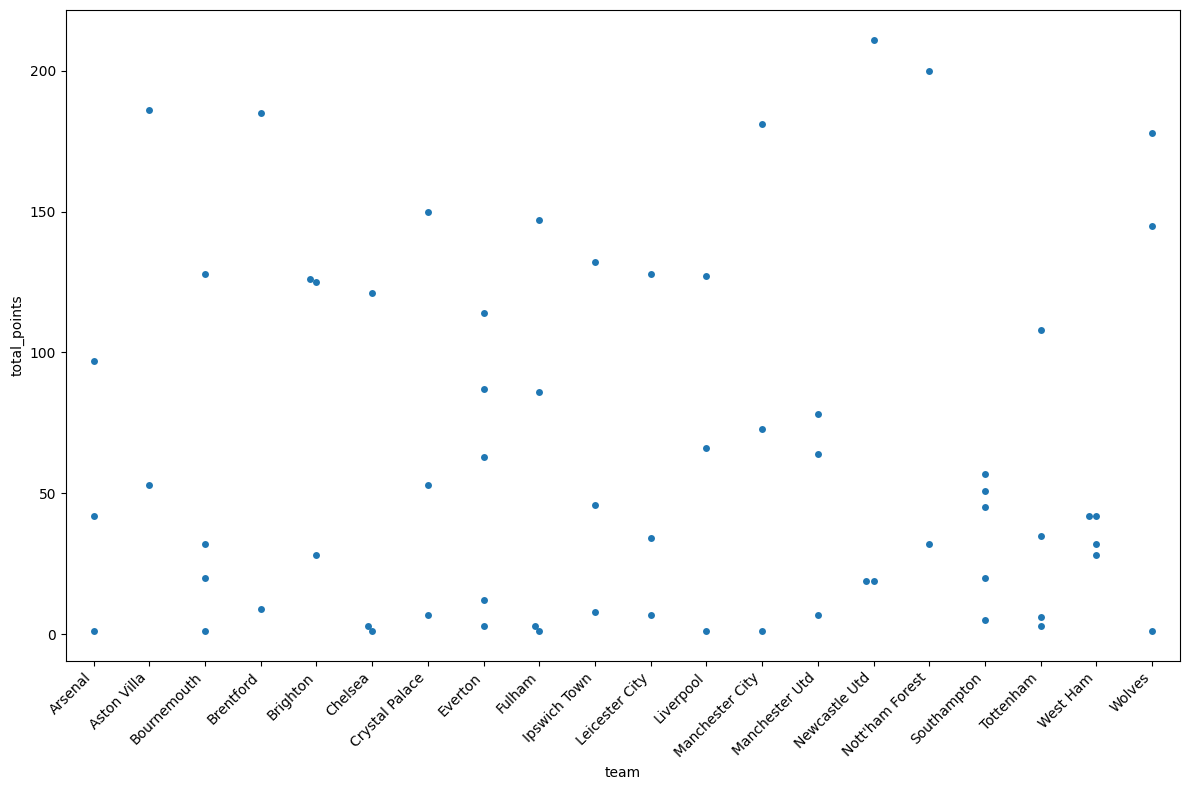

In [5]:
plt.figure(figsize=(12, 8))
sns.swarmplot(data=df_fwd, x="team", y="total_points")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [6]:
df_fwd_starter = df_fwd[df_fwd["playing_time_min"] > 1500]
df_fwd_starter["defensive_actions_points"] = df_fwd_starter["defensive_actions_per_90"].apply(estimate_defensive_contribution_points) * (df_fwd_starter["playing_time_min"] / 90)

/tmp/ipykernel_323651/2096459882.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fwd_starter["defensive_actions_points"] = df_fwd_starter["defensive_actions_per_90"].apply(estimate_defensive_contribution_points) * (df_fwd_starter["playing_time_min"] / 90)


<Axes: xlabel='expected_npxg/sh', ylabel='total_points'>

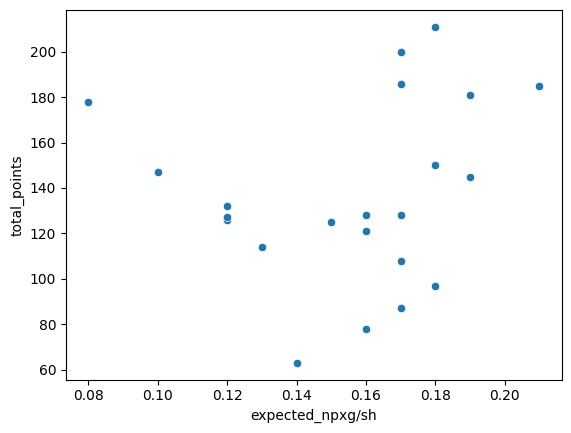

In [7]:
sns.scatterplot(data=df_fwd_starter, x="expected_npxg/sh", y="total_points")

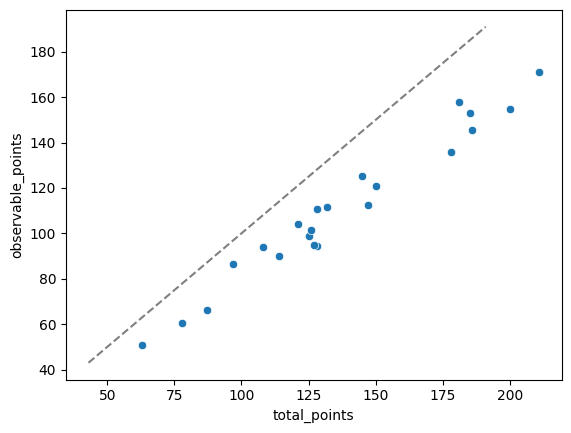

In [8]:
sns.scatterplot(data=df_fwd_starter, x="total_points", y="observable_points")
plt.plot(
    [df_fwd_starter["total_points"].min() - 20, df_fwd_starter["total_points"].max() - 20],
    [df_fwd_starter["total_points"].min() - 20, df_fwd_starter["total_points"].max() - 20],
    ls="--", color="gray"
)

In [9]:
Y = df_fwd_starter["observable_points"]
X = df_fwd_starter[[
    "expected_npxg+xag",
    "progression_prgp",
    "touches_mid_3rd"
]]
model = sm.OLS(Y, X).fit()
print(rmse(Y, model.fittedvalues))
print(model.summary())

14.252941072639125
                                 OLS Regression Results                                
Dep. Variable:      observable_points   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.982
Method:                 Least Squares   F-statistic:                              408.7
Date:                Thu, 14 Aug 2025   Prob (F-statistic):                    1.99e-17
Time:                        15:17:23   Log-Likelihood:                         -89.670
No. Observations:                  22   AIC:                                      185.3
Df Residuals:                      19   BIC:                                      188.6
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------

In [10]:
new_input = pd.DataFrame(
    {
        "expected_npxg+xag": [21.8],
        "progression_prgp": [20],
        "touches_mid_3rd": [222],
    }
)

print(model.predict(new_input))


0    157.957522
dtype: float64


In [11]:
df_fwd["predicted_points"] = model.predict(
    df_fwd[["expected_npxg+xag", "progression_prgp", "touches_mid_3rd"]]
)
df_fwd["residual_points"] = df_fwd["total_points"] - df_fwd["predicted_points"]
df_fwd["residual_per_90"] = df_fwd["residual_points"] / (df_fwd["playing_time_min"] / 90)

/tmp/ipykernel_323651/1403739191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fwd["predicted_points"] = model.predict(
/tmp/ipykernel_323651/1403739191.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fwd["residual_points"] = df_fwd["total_points"] - df_fwd["predicted_points"]
/tmp/ipykernel_323651/1403739191.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [12]:
df_fwd[df_fwd["playing_time_min"] <= 1000].sort_values(by="total_points", ascending=False)[[
    "player", "playing_time_starts", "playing_time_min", "points_per_90", "residual_per_90"
]]

,player,playing_time_starts,playing_time_min,points_per_90,residual_per_90
245,Rodrigo Muniz,8,964,8.029046,3.048044
38,Jáder Durán,4,638,7.476489,1.495493
265,George Hirst,5,661,6.263238,3.613462
5,Gabriel Jesus,6,608,6.217105,1.562001
537,Niclas Füllkrug,6,790,4.784810,0.162962
535,Michail Antonio,11,836,4.521531,0.783357
507,Richarlison,4,504,6.250000,-0.361165
308,Patson Daka,6,736,4.157609,1.519987
521,Danny Ings,1,284,10.140845,1.601566
61,Enes Ünal,2,345,8.347826,2.148686
